# Detecting the rectangle of the rice leaf
## This pybook is first of the development process

In [2]:
import tensorflow as tf
import numpy as np


In [3]:
STD_SIZE: int = 1600


def load_image(filepath: str):
    file_content = tf.io.read_file(filepath)
    image = tf.io.decode_jpeg(file_content, channels=3)  # load in RGB
    return tf.image.resize(image, [STD_SIZE, STD_SIZE])  # don't forget to uniform our image

In [4]:
import PIL

image = load_image("RiceLeafs/train/Healthy/IMG_20190419_123623.jpg")
image = tf.cast(image, tf.float32)
image = tf.expand_dims(image, 0)

sobel = tf.image.sobel_edges(image)
sobel_y = np.asarray(sobel[0, :, :, :, 0])  # sobel in y-direction
sobel_x = np.asarray(sobel[0, :, :, :, 1])  # sobel in x-direction

PIL.Image.fromarray(sobel_y[..., 0]).show()
PIL.Image.fromarray(sobel_x[..., 0]).show()

2022-01-16 20:44:45.393130: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-16 20:44:45.394504: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
import cv2

#reading the image
image = cv2.imread("RiceLeafs/train/Healthy/IMG_20190419_123623.jpg")
image = cv2.resize(image, (1600, 1600))
edged = cv2.Canny(image, 10, 220)
#cv2.imshow("Edges", edged)
#cv2.waitKey(0)

#applying closing function
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
#cv2.imshow("Closed", closed)
#cv2.waitKey(0)

#finding_contours
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
cv2.imshow("Output", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
def find_longest_dicks(contours) -> list:  # distance in contours klist
    full_list = []
    for c in contours:
        peri = cv2.arcLength(c, True)
        poly = cv2.approxPolyDP(c, 0.02 * peri, True)
        for lin_i in range(len(poly))[:-1]:
            full_list.append(((poly[lin_i][0][0], poly[lin_i][0][1]), (poly[lin_i + 1][0][0], poly[lin_i + 1][0][1])))
    full_list = sorted(full_list, key=lambda x: -(x[0][0] - x[1][0]) ** 2 - (x[0][1] - x[1][1]) ** 2)
    return full_list


In [31]:
import cv2
from scipy import ndimage
import numpy as np
import PIL
from matplotlib.pyplot import imshow
% matplotlib inline

scharr = np.array([[1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 0, 0, 0, 1, 1],
                   [1, 1, 0, 0, 0, 1, 1],
                   [1, 1, 0, 0, 0, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1, 1, 1]])

sharpen = np.array([[0, 0, 0, -1, 0, 0, 0],
                    [0, 0, -1, -1, -1, 0, 0],
                    [0, -1, -1, -1, -1, -1, 0],
                    [-1, -1, -1, 24, -1, -1, -1],
                    [0, -1, -1, -1, -1, -1, 0],
                    [0, 0, -1, -1, -1, 0, 0],
                    [0, 0, 0, -1, 0, 0, 0]])

new_conv = np.array([[0, -1, 0],
                     [-1, 5, -1],
                     [0, -1, 0]])

image = cv2.imread("RiceLeafs/train/Healthy/IMG_20190419_123646.jpg")
image = cv2.resize(image, (1600, 1600))
no_green_image = image.copy()
no_green_image[:, :, 1] = 0
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=21)
grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=21)

abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)

grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
grad_norm = (grad * 255 / grad.max()).astype(np.uint8)
grad_zero = grad_norm.copy()
grad_zero[np.abs(grad_zero) < 64] = 0
grad_zero = grad_zero.astype(np.float)
grad_cnn = ndimage.convolve(grad_zero, sharpen, mode='constant', cval=0.0)
grad_cnn[grad_cnn > 255] = 255
grad_cnn[grad_cnn < 64] = 0
grad_cnn = grad_cnn.astype(np.uint8)
print(grad_cnn.min(), grad_cnn.max())

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
closed = cv2.morphologyEx(grad_cnn, cv2.MORPH_CLOSE, kernel)

(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    #print(approx, len(approx))
    cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)

longest = find_longest_dicks(cnts)
for line in longest[:2]:
    cv2.line(image, line[0], line[1], color=(255, 0, 0), thickness=2)

#imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
#imshow(image)

#grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

#PIL.Image.fromarray(grad_x  ).show()
#PIL.Image.fromarray(grad_y  ).show()
#PIL.Image.fromarray(grad_norm  ).show()
#PIL.Image.fromarray(closed  ).show()
PIL.Image.fromarray(image).show()
#PIL.Image.fromarray(grad_zero  ).show()
#PIL.Image.fromarray(np.absolute(grad_cnn)  ).show()
#cv2.imshow('grad X',grad_x)
#cv2.imshow('grad Y',grad_y)
#cv2.imshow('Sobel Image',grad)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

/tmp/ipykernel_6171/2810790340.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  grad_zero = grad_zero.astype(np.float)


0 255


In [1]:
import cv2
import PIL
from scipy import ndimage
import numpy as np
import os
from math import sqrt, atan, pi, atan2
from sys import stderr


def find_longest_dicks(contours) -> list:  # distance in contours klist
    full_list = []
    for c in contours:
        peri = cv2.arcLength(c, True)
        poly = cv2.approxPolyDP(c, 0.02 * peri, True)
        for lin_i in range(len(poly))[:-1]:
            full_list.append(((poly[lin_i][0][0], poly[lin_i][0][1]), (poly[lin_i + 1][0][0], poly[lin_i + 1][0][1])))
    full_list = sorted(full_list, key=lambda x: -(x[0][0] - x[1][0]) ** 2 - (x[0][1] - x[1][1]) ** 2)
    return full_list


# k = (y1 - y2) / (x1 - x2)
# b = y2 - k*x2

def line_koeff(line: tuple[tuple[int, int], tuple[int, int]]) -> tuple[float, float]:
    k = (line[0][1] - line[1][1]) / (line[0][0] - line[1][0])
    b = line[1][1] - k * line[1][0]
    return k, b


def angle_diff(lhs, rhs) -> float:
    k_l, _ = line_koeff(lhs)
    k_r, _ = line_koeff(rhs)
    return abs(atan(k_l) - atan(k_r))

def line_len_f(x):
    return sqrt((x[0][0] - x[1][0]) ** 2 + (x[0][1] - x[1][1]) ** 2)


sharpen_cnn = np.array([[0, 0, 0, -1, 0, 0, 0],
                        [0, 0, -1, -1, -1, 0, 0],
                        [0, -1, -1, -1, -1, -1, 0],
                        [-1, -1, -1, 24, -1, -1, -1],
                        [0, -1, -1, -1, -1, -1, 0],
                        [0, 0, -1, -1, -1, 0, 0],
                        [0, 0, 0, -1, 0, 0, 0]])

len_threshold_1 = 0.40
len_threshold_other = 0.8
angle_diff_threshold = 10 * (pi / 180)
OUT_W, OUT_H = 600, 100

# TODO compare results with and without shadow removal
def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

def find_candidate_lines(image_data) -> list:
    #gray = cv2.cvtColor(shadow_remove(image_data), cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY) # TODO cmp

    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=21)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=21)

    grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
    grad_norm = (grad * 255 / grad.max()).astype(np.uint8)
    grad_zero = grad_norm.copy()
    grad_zero[np.abs(grad_zero) < 64] = 0
    grad_zero = grad_zero.astype(np.float)
    grad_cnn = ndimage.convolve(grad_zero, sharpen_cnn, mode='constant', cval=0.0)
    grad_cnn[grad_cnn > 255] = 255
    grad_cnn[grad_cnn < 64] = 0
    grad_cnn = grad_cnn.astype(np.uint8)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(grad_cnn, cv2.MORPH_CLOSE, kernel)

    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    all_dicks = find_longest_dicks(cnts)
    longest = all_dicks[:min(10, len(all_dicks))]

    # here we filter dicks that are not big enough
    if len(longest) <= 2:
        return longest
    target = list()
    target.append(longest[0])  # at least 1 should be here
    current_thr = len_threshold_1
    for line in longest[1:]:
        prev_len = line_len_f(target[-1])
        current_len = line_len_f(line)
        if current_len < prev_len * current_thr:
            break
        if angle_diff(target[0], line) > angle_diff_threshold:
            continue
        target.append(line)
        current_thr = len_threshold_other

    return target

def restrict(x, mn, mx):
    return int(max(mn, min(mx, x)))

def find_intersection(k1: float, b1: float, k2: float, b2: float, x1: float, size: int) -> tuple[float, float]:
    y1 = k1 * x1 + b1
    x_r = (y1 + x1 / k1 - b2) / (k2 + 1 / k1)
    y_r = x_r * k2 + b2
    print(k1, b1, k2, b2, x1, x_r, y_r)
    if x_r < -1:
        #return int(0), int(b2)
        #return find_intersection(k1, b1, k2, b2, x1 - x_r, size)
        res = find_intersection(k2, b2, k1, b1, 1, size)
        return find_intersection(k1, b1, k2, b2, res[0], size)
    elif y_r < -1:
        #return int(-b2 / k2), int(0)
        #return find_intersection(k1, b1, k2, b2, x1 - y_r / k1, size)
        res = find_intersection(k2, b2, k1, b1, (-b2) / k2, size)
        return find_intersection(k1, b1, k2, b2, res[0], size)
    elif x_r > size:
        #return int(size - 1), int((size - 1) * k2 + b2)
        #return find_intersection(k1, b1, k2, b2, x1 + (size - x_r), size)
        res = find_intersection(k2, b2, k1, b1, (size - 1), size)
        return find_intersection(k1, b1, k2, b2, res[0], size)
    elif y_r > size:
        #return int((size - 1) - b2 / k2), int((size - 1))
        #return find_intersection(k1, b1, k2, b2, x1 + (size - y_r) / k1, size)
        res = find_intersection(k2, b2, k1, b1, (((size - 1) - b2) / k2), size)
        return find_intersection(k1, b1, k2, b2, res[0], size)
    return x_r, y_r

def spec_atan2(y, x):
    res = atan2(y, x)
    print(res, y, x)
    return res

def sort_counterclock(pts: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    avg_x, avg_y = (pts[0][0] + pts[1][0] + pts[2][0] + pts[3][0]) / 4, (pts[0][1] + pts[1][1] + pts[2][1] + pts[3][1]) / 4
    result = list(pts)
    print("Points: ", result)
    result = sorted(result, key=lambda pt: atan2((pt[0] - avg_x), (pt[1] - avg_y)))
    #result = sorted(result, key=lambda pt: spec_atan2((pt[1] - avg_y), (pt[0] - avg_x)))
    for pt in result:
        print("pt({}, {}) from avg({}, {}): atan2 = {}".format(pt[0], pt[1], avg_x, avg_y, atan2((pt[0] - avg_x), (pt[1] - avg_y))))
    if line_len_f((result[0], result[1])) > line_len_f((result[1], result[2])):
        return result[1], result[2], result[3], result[0]
    return result[0], result[1], result[2], result[3]

def normalize_fit_tetragon(tetragon: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]], size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    result = list()
    for x in tetragon:
        result.append((min(size, max(0, x[0])), min(size, max(0, x[1]))))
    return result[0], result[1], result[2], result[3]

def extract_maiha(image: np.ndarray, tetragon: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]) -> np.ndarray:
    #inp_pts = np.array(tetragon, dtype=float)
    # 0231
    stetra = sort_counterclock(tetragon)
    inp_pts = np.array(stetra, dtype=np.float32)
    outp_pts = np.array([[0, 0], [0, OUT_H], [OUT_W, OUT_H], [OUT_W, 0]], dtype=np.float32)
    print(inp_pts)
    print(outp_pts)
    transform_mat = cv2.getPerspectiveTransform(inp_pts, outp_pts)
    return cv2.warpPerspective(image, transform_mat, (OUT_W, OUT_H), flags=cv2.INTER_LINEAR)

def find_rect_by_two_lines(line_ichi: tuple[tuple[int, int], tuple[int, int]], k2: float, b2: float, size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    k1, b1 = line_koeff(line_ichi)
    sanme_point = find_intersection(k1, b1, k2, b2, line_ichi[0][0], size)
    yonme_point = find_intersection(k1, b1, k2, b2, line_ichi[1][0], size)
    sanme_point = restrict(sanme_point[0], 0, size-1), restrict(sanme_point[1], 0, size-1)
    yonme_point = restrict(yonme_point[0], 0, size-1), restrict(yonme_point[1], 0, size-1)
    return normalize_fit_tetragon((line_ichi[0], line_ichi[1], sanme_point, yonme_point), size)

# there we have two lines
# with that information we can find intersections
# size is the image limit
def find_tetragon_hinted(line_ichi: tuple[tuple[int, int], tuple[int, int]], line_ni: tuple[tuple[int, int], tuple[int, int]], size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    k2, b2 = line_koeff(line_ni)
    return find_rect_by_two_lines(line_ichi, k2, b2, size)

def get_rect_hinted(image: np.ndarray, line_ichi: tuple[tuple[int, int], tuple[int, int]], line_ni: tuple[tuple[int, int], tuple[int, int]], size: int) -> np.ndarray:
    return extract_maiha(image, find_tetragon_hinted(line_ichi, line_ni, size))

def is_valid_rect(rect: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]], size: int) -> bool:
    for x in rect:
        if x[0] >= size or x[1] >= size or x[0] < 0 or x[1] < 0:
            return False
    return True

def rm_background(image: np.ndarray) -> np.ndarray:
    lower = np.array([128, 64, 128])
    upper = np.array([255, 255, 255])
    thresh = cv2.inRange(image, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    mask = 255 - morph
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

def compute_image_score(image: np.ndarray, hght: float) -> float: # we should keep it as low as possible
    #no_green_image: np.ndarray = image.copy()
    #no_green_image[:, :, 1] = 0
    #return float(np.sum(image, dtype=float) + 1) / (image.shape[0] * image.shape[1] * image.shape[2])

    nonz = float(np.count_nonzero(image))
    all_pix = image.shape[0] * image.shape[1] * image.shape[2]
    score = ((hght) ** (1)) * ((all_pix - nonz + 1))

    cv2.imshow('score {}, h:{}, nonz: {}, all: {}'.format(int(score), int(hght), int(nonz), int(all_pix)), image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return score # return black only

# just for testing purposes
def find_rect_no_hint(image: np.ndarray, line: tuple[tuple[int, int], tuple[int, int]], size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    b_step = 2 ** 8
    k1, b1 = line_koeff(line)
    result: tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]] = (0, 0), (0, 0), (0, 0), (0, 0)
    k_c, b_c = k1, b1
    scoring_image = rm_background(image)
    while b_step >= 1:
        kl, bl = k_c, b_c + b_step # low
        kh, bh = k_c, b_c - b_step # high
        rect_l, rect_h = find_rect_by_two_lines(line, kl, bl, size), find_rect_by_two_lines(line, kh, bh, size)
        img_l = extract_maiha(scoring_image, rect_l)
        img_h = extract_maiha(scoring_image, rect_h)
        score_l = compute_image_score(img_l, abs(b1 - bl)) # TODO NEEDS HEAVY ADJUSTMENTS
        score_h = compute_image_score(img_h, abs(b1 - bh)) # CURRENT BUG!!!!!!
        if score_l < score_h:
            k_c, b_c = kl, bl
            result = rect_l
        else:
            k_c, b_c = kh, bh
            result = rect_h
        b_step = int(b_step / 2)
    return result


def get_rect_no_hint(image: np.ndarray, line: tuple[tuple[int, int], tuple[int, int]], size: int) -> np.ndarray:

    return None

def process_image(image: np.ndarray, size: int) -> np.ndarray:
    lines = find_candidate_lines(image)
    if 0 and len(lines) > 1:
        return get_rect_hinted(image, lines[0], lines[1], size)
    elif len(lines) >= 1:
        return get_rect_no_hint(image, lines[0], size)
    return cv2.resize(image, (OUT_W, OUT_H))

def process_image_get_lines(image: np.ndarray, size: int) -> tuple[tuple[int, int], tuple[int, int], tuple[int, int], tuple[int, int]]:
    lines = find_candidate_lines(image)
    if 0 and len(lines) > 1:
        res = find_tetragon_hinted(lines[0], lines[1], size)
        for x in res:
            if x[0] >= size or x[1] >= size or x[0] < 0 or x[1] < 0:
                print("hinted failure", x[0], x[1], file=stderr)
        return res
    elif len(lines) >= 1:
        res = find_rect_no_hint(image, lines[0], size)
        for x in res:
            if x[0] >= size or x[1] >= size or x[0] < 0 or x[1] < 0:
                print("no hint failure", x[0], x[1], file=stderr)
        return res
    return (0, 0), (0, size), (size, size), (size, 0)

def show_draw_lines(path: str):
    image = cv2.imread(path)
    image = cv2.resize(image, (1600, 1600))
    lines = find_candidate_lines(image)
    for line in lines:
        cv2.line(image, line[0], line[1], color=(255, 0, 0), thickness=2)

    PIL.Image.fromarray(image).show()


def process_folder_draw_lines(folder: str, target_folder: str):
    files = os.listdir(folder)
    for filename in files[:100]:
        image = cv2.imread(os.path.join(folder, filename))
        image = cv2.resize(image, (1024, 1024))
        lines = find_candidate_lines(image)
        for line in lines:
            cv2.line(image, line[0], line[1], color=(0, 0, 255), thickness=2)
        cv2.imwrite(os.path.join(target_folder, filename), image)

def process_folder_draw_tetra(folder: str, target_folder: str):
    files = os.listdir(folder)
    for filename in files[:10]:
        image = cv2.imread(os.path.join(folder, filename))
        image = cv2.resize(image, (1024, 1024))
        print(filename, file=stderr)
        tetra = process_image_get_lines(image, 1024)
        #cv2.drawContours(image, [approx], -1, (0, 255, 0), 2)
        #print(np.array(tetra))
        cv2.drawContours(image, [np.array(sort_counterclock(tetra), dtype=np.int)], -1, (0, 0, 255), 2)
        cv2.imwrite(os.path.join(target_folder, filename), image)

def process_folder_extract(folder: str, target_folder: str):
    files = os.listdir(folder)
    for filename in files[:10]:
        image = cv2.imread(os.path.join(folder, filename))
        image = cv2.resize(image, (1024, 1024))
        print(filename, file=stderr)
        extracted = process_image(image, 1024)
        cv2.imwrite(os.path.join(target_folder, filename), extracted)


#show_draw_lines("RiceLeafs/train/Healthy/IMG_20190419_123646.jpg")
#process_folder_draw_lines("RiceLeafs/train/Healthy", "test")
#process_folder_extract("RiceLeafs/train/Healthy", "test")
process_folder_draw_tetra("RiceLeafs/train/Healthy", "test_lines")

TypeError: 'type' object is not subscriptable

In [ ]:
import cv2
import numpy as np

def warpImage(image, corners, target):
    #mat = cv2.CreateMat(3, 3, cv2.CV_32F)
    mat = np.zeros((3, 3), dtype=np.float64)
    cv2.getPerspectiveTransform(corners, target, mat)
    #out = cv2.CreateMat(height, width, cv2.CV_8UC3)
    out = np.zeros((height, width, 3), dtype=np.uint8)
    cv2.warpPerspective(image, out, mat, cv2.INTER_CUBIC)
    return out

if __name__ == '__main__':
    width, height = 400, 250
    corners = [(171,72),(331,93),(333,188),(177,210)]
    target = [(0,0),(width,0),(width,height),(0,height)]
    image = cv2.LoadImageM('fries.jpg')
    out = warpImage(image, corners, target)
    cv2.SaveImage('fries_warped.jpg', out)

In [6]:
import tensorflow as tf
from keras.layers import Input, Lambda, Dense, Flatten,GlobalAveragePooling2D,BatchNormalization,Dropout,Activation
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [7]:
train_dir = 'RiceLeafs/train'
test_dir = 'RiceLeafs/validation'
classes=[]
for file in os.listdir(train_dir):
    classes+=[file]
print(classes)
print(len(classes))

['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
4


In [8]:
brownSpot = [train_dir + '/BrownSpot/' + img for img in os.listdir(train_dir + '/BrownSpot')[:9]]
healthy = [train_dir  + '/Healthy/' + img for img in os.listdir(train_dir + '/Healthy')[:9]]
hispa = [train_dir  + '/Hispa/' + img for img in os.listdir(train_dir + '/Hispa')[:9]]
leafBlast = [train_dir  + '/LeafBlast/' + img for img in os.listdir(train_dir + '/LeafBlast')[:9]]

In [9]:
dataset=[]
shape=(600,100)
count=0
for file in os.listdir(train_dir):
    path=os.path.join(train_dir,file)
    t=0
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=shape)
        image=img_to_array(image)
        image=image/255.0
        dataset+=[[image,count]]
        t+=1
    count=count+1

In [10]:
testset=[]
count=0
for file in os.listdir(test_dir):
    path=os.path.join(test_dir,file)
    t=0
    for im in os.listdir(path):
        image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=shape)
        image=img_to_array(image)
        image=image/255.0
        testset+=[[image,count]]
        t+=1
    count=count+1

In [11]:
data,trainlabels = zip(*dataset)
test,testlabels = zip(*testset)
labels1=to_categorical(trainlabels)
labels=np.array(labels1)
data=np.array(data)
test=np.array(test)
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=42)
print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(2147, 600, 100, 3)
(537, 600, 100, 3)
(2147, 4)
(537, 4)


In [12]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30,zoom_range=0.2,
                             width_shift_range=0.1,height_shift_range=0.2,shear_range=0.2)

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation = 'relu',input_shape = (600,100,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256,activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(4,activation = 'softmax')

],    name = 'Conv2D_Model')

model.summary()

Model: "Conv2D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 598, 98, 16)       448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 299, 49, 16)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 297, 47, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 148, 23, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 146, 21, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 10, 64)      

In [17]:
LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [18]:
his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=10)

Epoch 1/10
68/68 [==============================] - 67s 981ms/step - loss: 1.3248 - accuracy: 0.4276 - val_loss: 1.2438 - val_accuracy: 0.4618
Epoch 2/10
68/68 [==============================] - 62s 913ms/step - loss: 1.2812 - accuracy: 0.4453 - val_loss: 1.1357 - val_accuracy: 0.5363
Epoch 3/10
68/68 [==============================] - 62s 909ms/step - loss: 1.2813 - accuracy: 0.4364 - val_loss: 1.2170 - val_accuracy: 0.4618
Epoch 4/10
68/68 [==============================] - 63s 926ms/step - loss: 1.2582 - accuracy: 0.4341 - val_loss: 1.2704 - val_accuracy: 0.4618
Epoch 5/10
68/68 [==============================] - 61s 900ms/step - loss: 1.2061 - accuracy: 0.4667 - val_loss: 1.2558 - val_accuracy: 0.5214
Epoch 6/10
68/68 [==============================] - 61s 898ms/step - loss: 1.2059 - accuracy: 0.4793 - val_loss: 1.1701 - val_accuracy: 0.5307
Epoch 7/10
68/68 [==============================] - 62s 910ms/step - loss: 1.1821 - accuracy: 0.5049 - val_loss: 1.1710 - val_accuracy: 0.5307

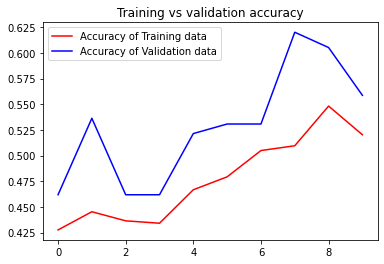

<Figure size 432x288 with 0 Axes>

In [19]:
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()